In [3]:
import os
import math
import random
import numpy as np
import tensorflow as tf
import cv2
import keyboard
import time
from pynput.mouse import Button, Controller
import wx
import playsound

In [3]:
slim = tf.contrib.slim
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
sys.path.append('../')
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [4]:
app = wx.App(False)
mouse = Controller()

In [7]:
playsound.playsound('mouse activated.mp3')
playsound.playsound('mouse deactivated.mp3')

In [6]:
screen_x, screen_y = wx.GetDisplaySize()

In [7]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

In [8]:
# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)


In [9]:
# Restore SSD model.
#ckpt_filename = r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\ssd_model_1\model.ckpt-25911'
ckpt_filename = r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\SSD-Tensorflow-master\train_model_fine_tune_2\model.ckpt-38961'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)
# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from C:\Users\PRAVEEN\Desktop\Capstone_ssd\SSD-Tensorflow-master\train_model_fine_tune_2\model.ckpt-38961


In [10]:
# Main image processing routine.
def process_image(img, select_threshold=0.2, nms_threshold=.8, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})

    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
        rpredictions, rlocalisations, ssd_anchors,
        select_threshold=select_threshold, img_shape=net_shape, num_classes=5, decode=True)

    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

In [12]:
cap = cv2.VideoCapture(0)
font = cv2.FONT_HERSHEY_SIMPLEX

pixel_threshold_1 = 30
pixel_threshold_2 = 100
pixel_threshold_3 = 40

#count_l_dir = 0
start_pauser = 0
start_appch = 0
start_mouse = 0
start_l_mouse = 0
start_lc = 0

count_dir = 0
count_appch = 0
count_l_appch = 0
count_m = 0
#count_lc = 0

click_flag = 1
mouse_active = 1
# Define the codec and create VideoWriter object
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))

while(True):
    
    
    #print(rclasses)
    # Capture frame-by-frame
    ret, img = cap.read()
    
    #if ret==True:
        #frame = cv2.flip(img,1)

        # write the flipped frame
        #out.write(frame)
    
    
    height = img.shape[0]
    width = img.shape[1]
    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    rclasses, rscores, rbboxes =  process_image(img)
    
    if time.time() - start_pauser > 1.5:
        count_dir = 0
        count_l_dir = 0
    
    if time.time() - start_appch > 1.5:
        if count_appch > 0:
            keyboard.release('alt')
        count_appch = 0
        count_l_appch = 0
        
        
    if time.time() - start_l_mouse > 2:
        count_m = 0

        
    
    if rclasses.any() > 0:
        #print(rclasses)
        ymin = int(rbboxes[0, 0] * height)
        xmin = int(rbboxes[0, 1] * width)
        ymax = int(rbboxes[0, 2] * height)
        xmax = int(rbboxes[0, 3] * width)
        # Display the resulting frame
        cv2.putText(img, (str(rclasses[0]) + "-" + str(rscores[0])),(xmax, ymax), font, 2, (26,255,255))
        #cv2.putText(img, str(rscores[0]),(int((xmax+xmin)/2), ymax), font, 2, (255,255,255))
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)
        cv2.imshow('frame',img)
        count_dir += 1
        count_appch += 1
        count_m += 1
        
        
        if (rclasses[0] in [4,5]) and mouse_active > 0:
            x_mid = (xmin + xmax)/2
            y_mid = (ymin + ymax)/2
            if count_dir == 1:
                start_pauser = time.time()
                x_mid_1 = x_mid
                y_mid_1 = y_mid
            elif ((count_dir > 1) and ((time.time() - start_pauser) > 0.5) and (x_mid < (x_mid_1 + pixel_threshold_1)) and (x_mid > (x_mid_1 - pixel_threshold_1)) and (y_mid < (y_mid_1 + pixel_threshold_1)) and (y_mid > (y_mid_1 - pixel_threshold_1))):
                keyboard.press_and_release('space')
                #print("space")
                time.sleep(0.75)
                #count = 0
            elif ((count_dir > 1) and (x_mid > (x_mid_1 + pixel_threshold_2)) and ((time.time() - start_pauser) > 0.15)):
                keyboard.press_and_release('left arrow')
                #print("left arrow")
                #if count_l > 3:
                #    keyboard.press('left arrow')
                #time.sleep(0.25)
                #count_l += 1
                start_pauser = time.time()
            elif ((count_dir > 1) and (x_mid < (x_mid_1 - pixel_threshold_2)) and ((time.time() - start_pauser) > 0.15)):
                keyboard.press_and_release('right arrow')
                #print("right arrow")
                #time.sleep(0.75)
                #count_l += 1
                start_pauser = time.time()
            elif ((count_dir > 1) and (y_mid > (y_mid_1 + pixel_threshold_3)) and ((time.time() - start_pauser) > 0.15)):
                #print('yyyyyyy')
                keyboard.press_and_release('down arrow')
                #time.sleep(0.75)
                #count_l += 1
                start_pauser = time.time()
            elif ((count_dir > 1) and (y_mid < (y_mid_1 - pixel_threshold_3)) and ((time.time() - start_pauser) > 0.15)):
                #print('nnnnnnnnnn')
                keyboard.press_and_release('up arrow')
                #time.sleep(0.75)
                #count_l += 1
                start_pauser = time.time()
                
                
        if (rclasses[0] in [3]) and mouse_active > 0:
            x_mid = (xmin + xmax)/2
            y_mid = (ymin + ymax)/2
            if count_appch == 1:
                start_appch = time.time()
            elif count_appch > 1 and (time.time() - start_appch) > 0.5 and count_l_appch == 0:
                x_mid_1 = x_mid
                y_mid_1 = y_mid
                keyboard.press('alt')
                count_l_appch += 1
            elif ((count_appch > 1) and (count_l_appch > 0) and ((time.time() - start_appch) > 0.15) and (x_mid < (x_mid_1 + pixel_threshold_1)) and (x_mid > (x_mid_1 - pixel_threshold_1)) and (y_mid < (y_mid_1 + pixel_threshold_1)) and (y_mid > (y_mid_1 - pixel_threshold_1))):
                keyboard.press_and_release('tab')
                time.sleep(0.75)
                start_appch = time.time()
        
        if rclasses[0] in [1]:
            if count_m == 1:
                start_mouse = time.time()
                start_l_mouse = time.time()
                print('hi')
            elif count_m > 1:
                start_l_mouse = time.time()
            if (time.time() - start_mouse) > 2:
                mouse_active = mouse_active * (-1)
                print(mouse_active)
                time.sleep(2)
        
        if mouse_active < 0:
            if rclasses[0] in [4]:
                #x_mid = (xmin + xmax)/2
                #y_mid = (ymin + ymax)/2
                #mouse.position = (screen_x -  (xmin * screen_x/(width - 150)), ymin * screen_y/(height - 200))
                x_mid = (width/2 - (xmin + xmax)/2)/10
                y_mid = ((ymin + ymax)/2 - height/2)/10
                #if x_mid > 0 :
                #    x_mid = 5
                #else:
                #    x_mid = -5
                #if y_mid > 0:
                #    y_mid = 5
                #else:
                #    y_mid = -5
                mouse.move(x_mid, y_mid)
                
            if rclasses[0] in [2]:
                if click_flag > 0:
                    mouse.press(Button.left)
                    click_flag = click_flag * (-1)
                start_lc = time.time()
                x_mid = (width/2 - (xmin + xmax)/2)/10
                y_mid = ((ymin + ymax)/2 - height/2)/10
                mouse.move(x_mid, y_mid)
                #count_lc += 1
            if (time.time() - start_lc) > 0.25 and click_flag < 0:
                mouse.release(Button.left)
                click_flag = 1
                #count_lc = 0
                
            if rclasses[0] in [5]:
                mouse.click(Button.left, 2)
                time.sleep(0.5)
                

                
                        
                        
                    
                
               
        #if rclasses[0] in [1,2,3]:    
            
            
        
    

        
    
    
    cv2.imshow('frame',img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
#out.release()
cv2.destroyAllWindows()

In [142]:
mouse.move(-100, -100)

In [147]:
height/2, width/2

(240.0, 320.0)

In [160]:
cap.release()
cv2.destroyAllWindows()

In [25]:
start = time.time() 

In [26]:
time.time() - start

1.13096022605896

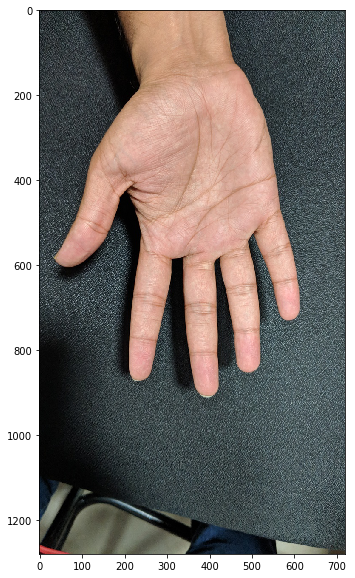

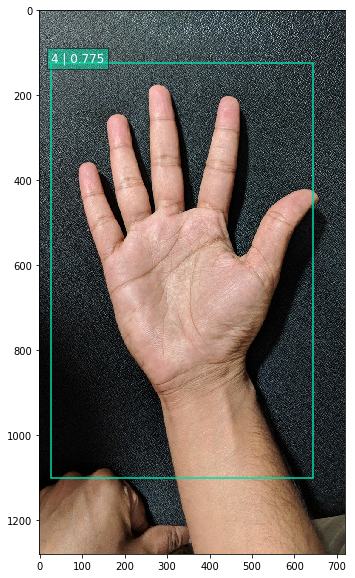

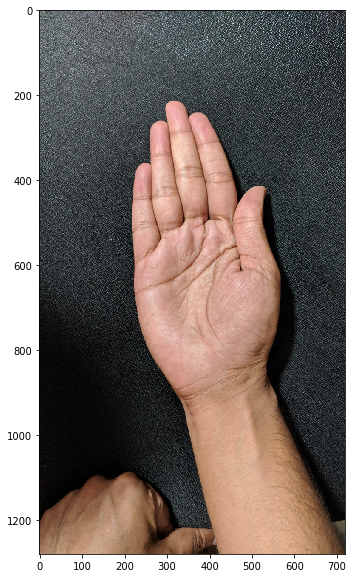

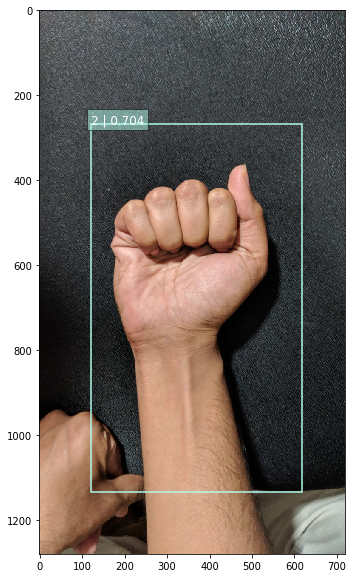

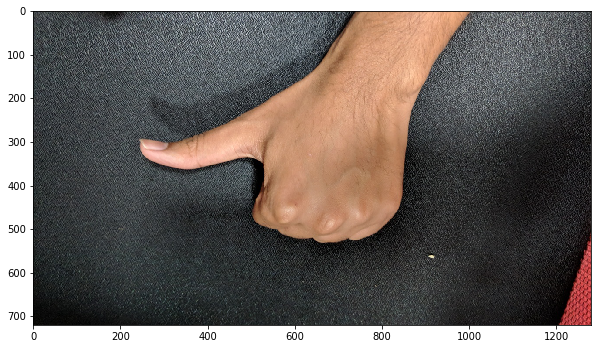

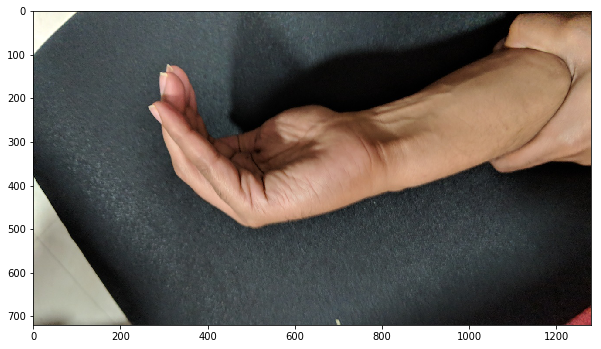

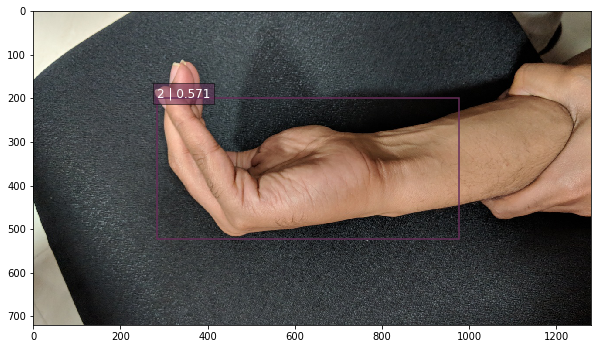

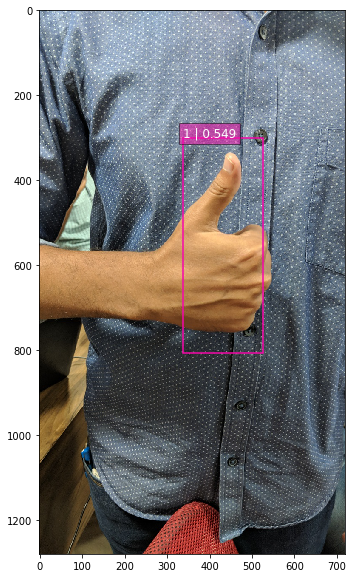

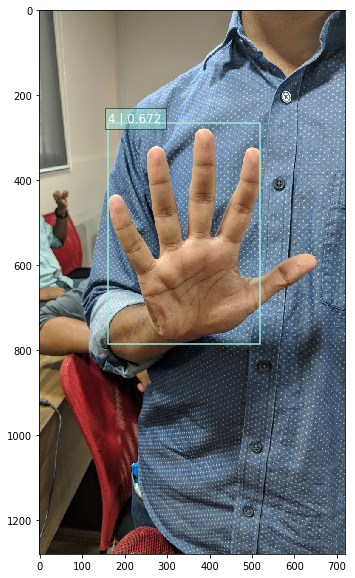

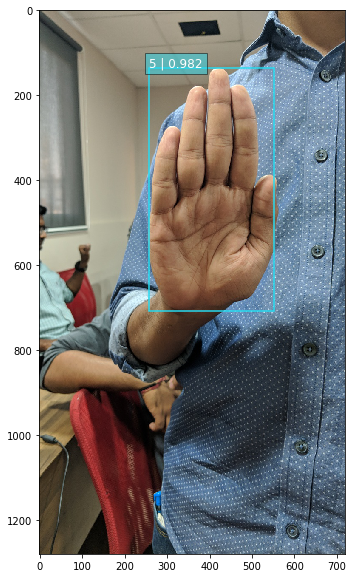

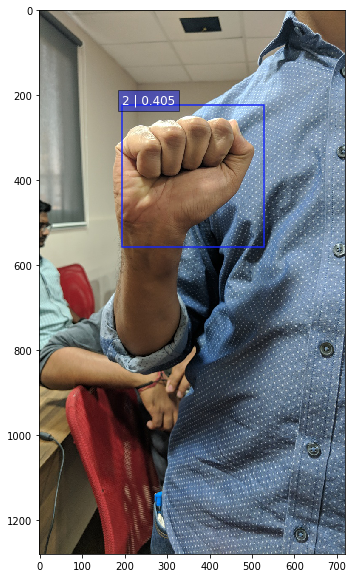

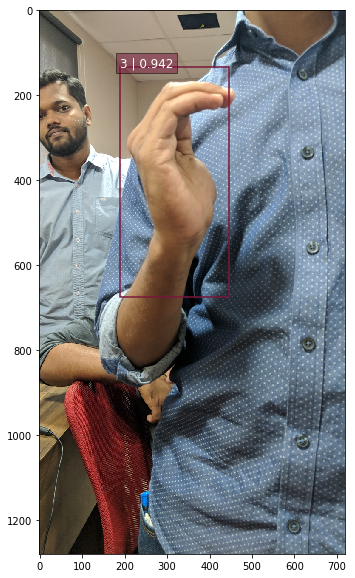

In [18]:
for i in range(len(image_names)):
    img = mpimg.imread(path + '\\' + image_names[i])
    rclasses, rscores, rbboxes =  process_image(img)
    visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [33]:
from tensorflow.python.tools.inspect_checkpoint import print_tensors_in_checkpoint_file
ckpt_path=r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\SSD-Tensorflow-master\model_testing\model.ckpt-26953'
print_tensors_in_checkpoint_file(file_name=ckpt_path, tensor_name='ssd_losses/softmax/Softmax', all_tensors=True, all_tensor_names=True)

tensor_name:  beta1_power
0.0
tensor_name:  beta2_power
1.9423243e-12
tensor_name:  global_step
26953
tensor_name:  ssd_300_vgg/block10/conv1x1/biases
[ 6.4959470e-03  1.0496835e-02 -3.6384324e-03 -4.2038877e-03
 -5.5762485e-04 -1.4044743e-04  2.4198414e-06  8.7846811e-06
  1.4457309e-03  2.2765288e-02 -5.3575179e-03  1.1442015e-02
  3.1626489e-02  3.2877556e-06  5.1216749e-03  3.1099511e-02
  8.4597552e-03  5.1592565e-03 -1.8350787e-02  5.0502629e-03
  9.7318329e-03  8.5826823e-03 -2.9443416e-03  2.2204408e-04
 -4.5488309e-03  3.8577416e-03  3.9587747e-02  2.0663634e-02
  1.8335653e-02 -7.8847923e-04  4.2604939e-03  1.1927651e-02
  3.8308668e-04  8.4722880e-03  8.8783803e-05  7.8056830e-05
  7.8015251e-04  1.6572790e-03  1.2618119e-02 -4.1640834e-03
  1.4946715e-02 -5.0916558e-05  3.5560585e-03 -3.1144042e-03
  5.6554793e-05  1.3587809e-03  6.5028914e-03  6.0748913e-05
 -9.4083726e-04  3.5788678e-02 -4.0855650e-03  1.9483420e-03
  8.2770335e-03  6.4086486e-03 -7.5451867e-04  1.5431009

[-6.0776547e-05  1.4761824e-05  5.5718730e-04  8.2145608e-04
  2.4778751e-04 -4.6232145e-04  1.3877727e-02  3.2884948e-02
 -2.3245884e-06 -1.2600311e-06 -1.8150641e-06  3.8767348e-06
  1.8136705e-05  1.7123423e-04  7.1919046e-04  2.2568805e-04]
tensor_name:  ssd_300_vgg/block4_box/conv_loc/biases/Adam
[ 3.0948771e-11  8.3213707e-11 -8.3213707e-11 -8.3213707e-11
  1.4175550e-06  2.6658777e-06 -1.7774974e-03 -2.4509025e-03
  1.1665542e-37  1.0703331e-37  1.1242567e-37 -1.1495850e-37
  1.0996857e-37  1.0655108e-37 -1.0996857e-37  1.0892528e-37]
tensor_name:  ssd_300_vgg/block4_box/conv_loc/biases/Adam_1
[5.8842477e-07 2.6172172e-06 3.0911992e-06 3.1424554e-06 1.2271521e-04
 2.0905652e-05 4.6241208e-04 8.2970812e-04 8.1547242e-08 2.3936623e-08
 4.9693693e-08 2.2712123e-07 4.9412665e-07 1.0567521e-07 1.7361627e-06
 7.1131331e-07]
tensor_name:  ssd_300_vgg/block4_box/conv_loc/weights
[[[[ 0.03136246  0.00174493 -0.02444427 ... -0.01298992 -0.00994158
    -0.03523625]
   [-0.01050324  0.01453

tensor_name:  ssd_300_vgg/conv2/conv2_1/weights
[[[[-8.90296325e-03  3.78169715e-02  1.39756575e-02 ... -6.35457635e-02
     2.83470433e-02 -5.54975234e-02]
   [-5.66543266e-03 -1.05560187e-03 -2.29203496e-02 ... -1.30956469e-03
     2.52478309e-02 -2.95403805e-02]
   [-7.85139855e-03 -4.38382570e-03 -1.29586197e-02 ...  1.22073088e-02
     4.46309976e-04 -2.49174051e-02]
   ...
   [-5.82487276e-03  3.78986611e-03 -1.48562957e-02 ...  1.27910008e-03
     1.27594778e-02 -1.33825615e-02]
   [-1.54342148e-02  5.62145375e-03  3.05225104e-02 ...  1.61413271e-02
    -4.20058556e-02 -3.35679092e-02]
   [-4.21814434e-03  2.95577031e-02  2.57514068e-03 ... -2.59456299e-02
    -1.35917868e-03 -5.85189313e-02]]

  [[-1.03394873e-02  3.75955850e-02  6.87777717e-03 ... -5.84545359e-02
     3.90824042e-02  3.70086096e-02]
   [ 4.86768410e-03  4.54719039e-03 -1.62224416e-02 ... -2.55017504e-02
     1.88396666e-02 -6.24489179e-03]
   [-5.31206699e-03 -1.19874987e-03 -1.11892410e-02 ...  1.98805016e-02

[[[[-4.89256112e-04  7.84685428e-04 -1.06644102e-05 ...  3.73512776e-05
     2.42452906e-03  1.84135686e-04]
   [ 6.37174817e-04  2.45262432e-04  2.03929347e-04 ...  9.27773290e-05
    -1.09813351e-04  2.14868502e-04]
   [ 6.51022769e-04  6.01324136e-04 -9.47904482e-06 ... -5.45327319e-04
     1.27099757e-03 -2.70681834e-04]
   ...
   [ 9.68903862e-03  3.01320106e-03 -3.08899023e-03 ... -9.19773302e-05
     2.59329751e-03 -1.56350841e-03]
   [ 1.67270575e-03 -1.24030208e-04 -4.12459340e-05 ...  2.52575031e-04
     2.59746192e-03 -1.49007491e-03]
   [-7.50666251e-04  3.83323757e-04 -4.83569966e-05 ... -9.72814451e-05
     8.72293953e-04 -7.43533834e-04]]

  [[-4.87257401e-03 -1.11455424e-03 -4.48676641e-04 ...  2.78666994e-04
     1.54174874e-02  2.17971887e-04]
   [-8.55824794e-04  2.56503816e-04 -2.81113375e-04 ...  3.17567785e-04
     1.85665337e-03  4.95645974e-04]
   [-1.00767519e-03  3.57889221e-05 -4.38705611e-04 ... -1.57805960e-04
     1.45244356e-02 -6.19028811e-04]
   ...
   

In [ ]:
from tensorflow.python.tools import freeze_graph

In [ ]:
freeze_graph.freeze_graph(r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\SSD-Tensorflow-master\train_model\graph.pbtxt', "", False, 
                          r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\SSD-Tensorflow-master\model_testing\model.ckpt-26953', "ssd_losses/softmax/Softmax",
                           "save/restore_all", "save/Const:0",
                           'frozentensorflowModel.pb', True, ""  
                         )

In [ ]:
# Jean Vitor de Paulo Blog - https://jeanvitor.com/tensorflow-object-detecion-opencv/
 
import cv2
 
# Load a model imported from Tensorflow
tensorflowNet = cv2.dnn.readNetFromTensorflow(r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\tensormodel.pb', r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\SSD-Tensorflow-master\train_model\graph.pbtxt')
 
# Input image
img = cv2.imread('img.jpg')
rows, cols, channels = img.shape
 
# Use the given image as input, which needs to be blob(s).
tensorflowNet.setInput(cv2.dnn.blobFromImage(img, size=(300, 300), swapRB=True, crop=False))
 
# Runs a forward pass to compute the net output
networkOutput = tensorflowNet.forward()
 
# Loop on the outputs
for detection in networkOutput[0,0]:
    
    score = float(detection[2])
    if score > 0.2:
    	
        left = detection[3] * cols
        top = detection[4] * rows
        right = detection[5] * cols
        bottom = detection[6] * rows
 
        #draw a red rectangle around detected objects
        cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0, 0, 255), thickness=2)
        
# Show the image with a rectagle surrounding the detected objects 
cv2.imshow('Image', img)
cv2.waitKey()
cv2.destroyAllWindows()

In [ ]:
import tensorflow as tf
import numpy as np
graph_filename = r"C:\Users\PRAVEEN\Desktop\Capstone_ssd\tensormodel.pb"
with tf.gfile.GFile(graph_filename, "rb") as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    tf.train.write_graph(graph_def, r'C:\Users\PRAVEEN\Desktop\Capstone_ssd', r'frozen_graph.pbtxt', True)

In [ ]:
cap = cv2.VideoCapture(0)

# Load a model imported from Tensorflow
tensorflowNet = cv2.dnn.readNetFromTensorflow(r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\tensormodel.pb')
 

while(True):
    # Capture frame-by-frame
    ret, img = cap.read()
    
    rows, cols, channels = img.shape
    
    # Use the given image as input, which needs to be blob(s).
    tensorflowNet.setInput(cv2.dnn.blobFromImage(img, size=(300, 300), swapRB=True, crop=False))

    # Runs a forward pass to compute the net output
    networkOutput = tensorflowNet.forward()
 
    # Loop on the outputs
    for detection in networkOutput[0,0]:

        score = floqat(detection[2])
        if score > 0.2:

            left = detection[3] * cols
            top = detection[4] * rows
            right = detection[5] * cols
            bottom = detection[6] * rows

            #draw a red rectangle around detected objects
            cv2.rectangle(img, (int(left), int(top)), (int(right), int(bottom)), (0, 0, 255), thickness=2)
            cv2.imshow('Image', img)

    
    # Our operations on the frame come here
    #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    #rclasses, rscores, rbboxes =  process_image(frame)
    #frame = visualization.plt_bboxes(frame, rclasses, rscores, rbboxes)
    # Display the resulting frame
    #cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

## Model testing

In [23]:
import numpy as np
import tensorflow as tf
import cv2 as cv

# Read the graph.
with tf.gfile.FastGFile(r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\tensormodel.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

with tf.Session() as sess:
    # Restore session
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

    # Read and preprocess an image.
    img = cv.imread(r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\SSD-Tensorflow-master\demo\IMG_20190313_180047.jpg')
    rows = img.shape[0]
    cols = img.shape[1]
    inp = cv.resize(img, (300, 300))
    inp = inp[:, :, [2, 1, 0]]  # BGR2RGB

    # Run the model
    out = sess.run([sess.graph.get_tensor_by_name('num_detections:0'),
                    sess.graph.get_tensor_by_name('detection_scores:0'),
                    sess.graph.get_tensor_by_name('detection_boxes:0'),
                    sess.graph.get_tensor_by_name('detection_classes:0')],
                   feed_dict={'image_tensor:0': inp.reshape(1, inp.shape[0], inp.shape[1], 3)})

    # Visualize detected bounding boxes.
    num_detections = int(out[0][0])
    for i in range(num_detections):
        classId = int(out[3][0][i])
        score = float(out[1][0][i])
        bbox = [float(v) for v in out[2][0][i]]
        if score > 0.3:
            x = bbox[1] * cols
            y = bbox[0] * rows
            right = bbox[3] * cols
            bottom = bbox[2] * rows
            cv.rectangle(img, (int(x), int(y)), (int(right), int(bottom)), (125, 255, 51), thickness=2)

cv.imshow('TensorFlow MobileNet-SSD', img)
cv.waitKey()

KeyError: "The name 'num_detections:0' refers to a Tensor which does not exist. The operation, 'num_detections', does not exist in the graph."

In [27]:
with tf.gfile.FastGFile(r'C:\Users\PRAVEEN\Desktop\Capstone_ssd\SSD-Tensorflow-master\frozentensorflowModel.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    print(graph_def.ParseFromString(f.read()))

None


In [14]:
rclasses = 2

In [16]:
rclasses in [1,3]

False